# Chapter 6. 일반선형모델

## 6.5 포아송 회귀

* 이 절에서는 포아송 회귀를 알아보고 파이선을 이용한 실천적 분석 방법을 설명함

    * 분석 순서는 로지스틱 회귀와 크게 다르지 않음


* **포아송 회귀** 란 확률분포에 포아송 분포를 사용하고, 링크함수에 로그함수를 사용한 일반 선형 모델임

    * 독립변수는 여러 개 있어도 상관없고, 연속형과 카테고리형이 혼재되어 있어도 됨

### 6.5.1 이 절의 예제

* 이 절의 예제에서는 맥주 판매 개수를 예측

* 기온에 의해 판매 개수가 바뀐다는 구조를 수리모델로 표현하면 선형예측자는 아래와 같아짐

$$\beta_0 + \beta_1 \times 기온 \left(^{\circ}C\right)$$

### 6.5.2 포아송 회귀의 구조

- 링크함수에 로그함수를 사용하면 맥주 판매 개수와 기온의 관계는 다음과 같이 됨

$$ log\left[ 맥주 판매 개수 \right] = \beta_0 + \beta_1 \times 기온 \left(^{\circ}C\right) $$

$$ 맥주 \, 판매 \, 개수 = exp \left[\beta_0 + \beta_1 \times 기온 \left(^{\circ}C\right) \right]$$

* 실제 맥주 판매 데이터를 얻었다고 할 때, 기온이 맥주 판매 개수에 영향을 주는지 조사 

* 맥주 판매 개수Y는 강도 $\lambda$ (평균값의 푸아송 분포를 따를 것이라고 예상)

$$ 맥주 \, 판매 \, 개수 : Y ~ Pois\left(y| exp \left[\beta_0 + \beta_1 \times 기온 \left(^{\circ}C\right) \right] \right)$$

$$ Pois\left(y| \lambda \right) = \frac{e^{-\lambda} \cdot \lambda^{y}}{y!} $$

### 6.5.3 분석 준비

In [1]:
# 수치계산에 사용되는 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 그래프를 그리기 위한 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 통계모델을 추정하는데 사용하는 라이브러리
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 표시 자릿수 지정
%precision 3

# 그래프를 주피터 노트북에 그리기 위한 설정
%matplotlib inline

In [2]:
# 데이터 불러오기 
beer = pd.read_csv("py_source/6-5-1-poisson-regression.csv")
print(beer.head(3))

   beer_number  temperature
0            6         17.5
1           11         26.6
2            2          5.0


### 6.5.4 포아송 회귀(실습)

* 포아송 회귀모델 추정

In [3]:
mod_pois = smf.glm("beer_number ~ temperature", beer, family = sm.families.Poisson()).fit()

In [4]:
mod_pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            beer_number   No. Observations:                   30
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.672
Date:                Sun, 18 Sep 2022   Deviance:                       5.1373
Time:                        19:13:29   Pearson chi2:                     5.40
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9708
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4476      0.199      2.253      0.024       0.058       0.837
temperature     0.0761      0.008      9.784      0.000       0.061       0.091
===============================================================================
"""

In [5]:
# 피어슨 카이제곱 통계량 검정
1 - stats.chi2.cdf(mod_pois.pearson_chi2, mod_pois.df_resid)

1.000

* 구축 모델에 대한 피어슨 카이제곱 통계량 검정 결과 P 값이 0.05 보다 크므로 '추정 모델이 적합하다'라는 귀무가설을 기각할 수 없음(적합결여 없음)

### 6.5.5 모델 선택

* **AIC** 를 사용한 모델 선택

In [6]:
# Null 모델 추정
mod_pois_null = smf.glm("beer_number ~ 1", data = beer, family = sm.families.Poisson()).fit()

* **AIC**를 비교하면 기온이라는 독립변수가 들어간 모델의 AIC가 작음 

    - 기온 독립변수가 필요함

In [7]:
print("Null 모델       : " , mod_pois_null.aic.round(3))
print("변수가 있는 모델: " , mod_pois.aic.round(3))

Null 모델       :  223.363
변수가 있는 모델:  119.343


### 6.5.6 회귀곡선 그래프

* 포아송 회귀의 경우에는 seaborn 함수로 그릴 수 없기 때문에 추정된 모델의 예측값을 산포도 위에 덧그림

In [8]:
# 변수들의 범위 확인
beer.describe()

,beer_number,temperature
count,30.000000,30.000000
mean,7.833333,18.063333
std,5.657362,9.169495
min,2.000000,5.000000
25%,4.000000,10.225000
50%,6.000000,17.200000
75%,11.000000,25.750000
max,22.000000,34.000000


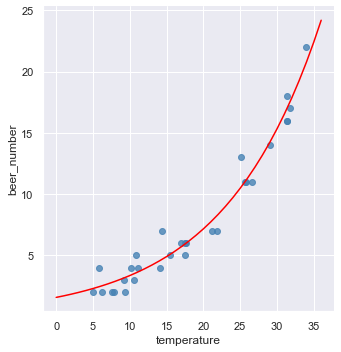

In [9]:
# 예측값 작성
x_plot = np.arange(0, 37) # 기온은 5도에서 34도 사이 분포하므로 적절한 구간을 잡음
pred = mod_pois.predict(pd.DataFrame({"temperature": x_plot}))

# 회귀곡선을 그리지 않은 lmplot
sns.lmplot(y = "beer_number", x = "temperature", data = beer, fit_reg = False,
           scatter_kws = {"color" : "steelblue"})
plt.plot(x_plot, pred, color = "red")

### 6.5.7 회귀계수 해석

* 링크함수가 항등함수가 아닐 경우에는 획득한 회귀계수의 해석이 바뀜(로그함수를 사용한 경우의 계수 해석 방법을 확인함)

* 로그의 특징은 덧셈이 곱셈이 된다는 점이 있음. 

    - 일반적인 모델에서는 기온이 1도 오르면 맥주 매출이 X원 증가한다는 해석이 되겠지만, 로그함수를 사용하면 기온이 1도 오르면 맥주 판매 개수가 Y배 된다는 해석이 됨

In [10]:
# 기온이 1도일 때의 판매 개수의 기댓값
exp_val_1 = pd.DataFrame({"temperature" : [1]})
pred_1 = mod_pois.predict(exp_val_1)

# 기온이 2도일 때의 판매 개수의 기댓값
exp_val_2 = pd.DataFrame({"temperature" : [2]})
pred_2 = mod_pois.predict(exp_val_2)

# 기온이 1도에서 1도 오르면 판매 개수는 몇 배가 되는가?
pred_2 / pred_1

0    1.079045
dtype: float64

- **(결과 해석)** 기온이 1도씨 오르면 맥주 판매 개수는 약 1.08배 증가

- 이는 회귀계수에 exp를 취한 값과 동일하며, **회귀계수에 exp 취한 값**이 바로 **독립변수($x$)가 1 증가할 때 발생하는 종속변수($y$)의 변화 또는 효과**라고 볼 수 있다.

    - 독립변수의 영향이 곱셈이 되는 것은 해석에 있어서 매우 중요하기 때문에 반드시 기억!

In [11]:
# 회귀계수에 exp 취한 결과 확인

np.exp(mod_pois.params["temperature"])

1.079